In [45]:
import argparse
import time
import abc
from functools import namedtuple
import numpy as np
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl import DGLGraph
from dgl.data import register_data_args, load_data, ppi
from dgl.nn.pytorch.conv import SAGEConv
import warnings
warnings.filterwarnings('ignore')

In [46]:
def load_ppi(args):
    train_dataset = ppi.PPIDataset('train')
    val_dataset = ppi.PPIDataset('valid')
    test_dataset = ppi.PPIDataset('test')
    PPIDataType = namedtuple('PPIDataset', ['train_mask', 'test_mask',
                                            'val_mask', 'features', 'labels', 'num_labels', 'graph'])
    G = dgl.BatchedDGLGraph(
        [train_dataset.graph, val_dataset.graph, test_dataset.graph], edge_attrs=None, node_attrs=None)
    G = G.to_networkx()
    # hack to dodge the potential bugs of to_networkx
    for (n1, n2, d) in G.edges(data=True):
        d.clear()
    train_nodes_num = train_dataset.graph.number_of_nodes()
    test_nodes_num = test_dataset.graph.number_of_nodes()
    val_nodes_num = val_dataset.graph.number_of_nodes()
    nodes_num = G.number_of_nodes()
    assert(nodes_num == (train_nodes_num + test_nodes_num + val_nodes_num))
    # construct mask
    mask = np.zeros((nodes_num,), dtype=bool)
    train_mask = mask.copy()
    train_mask[:train_nodes_num] = True
    val_mask = mask.copy()
    val_mask[train_nodes_num:-test_nodes_num] = True
    test_mask = mask.copy()
    test_mask[-test_nodes_num:] = True

    # construct features
    features = np.concatenate(
        [train_dataset.features, val_dataset.features, test_dataset.features], axis=0)

    labels = np.concatenate(
        [train_dataset.labels, val_dataset.labels, test_dataset.labels], axis=0)

    data = PPIDataType(graph=G, train_mask=train_mask, test_mask=test_mask,
                       val_mask=val_mask, features=features, labels=labels, num_labels=121)
    return data


In [50]:
loss_val = []
f1_val = []

def main(args):
    # load and preprocess dataset
    data = load_ppi(args)
    #data = ppi.PPIDataset('train')
    features = torch.FloatTensor(data.features)
    labels = torch.FloatTensor(data.labels)
    train_mask = torch.ByteTensor(data.train_mask)
    val_mask = torch.ByteTensor(data.val_mask)
    test_mask = torch.ByteTensor(data.test_mask)
    in_feats = features.shape[1]
    n_classes = data.num_labels
    n_edges = data.graph.number_of_edges()
    print("""----Data statistics------'
      #Edges %d
      #Classes %d
      #Train samples %d
      #Val samples %d
      #Test samples %d""" %
          (n_edges, n_classes,
           train_mask.sum().item(),
           val_mask.sum().item(),
           test_mask.sum().item()))

    if args.gpu < 0:
        cuda = False
    else:
        cuda = True
        torch.cuda.set_device(args.gpu)
        features = features.cuda()
        labels = labels.cuda()
        train_mask = train_mask.cuda()
        val_mask = val_mask.cuda()
        test_mask = test_mask.cuda()
        print("use cuda:", args.gpu)

    # graph preprocess and calculate normalization factor
    g = data.graph
    #g.remove_edges_from(g.selfloop_edges())
    g = DGLGraph(g)
    n_edges = g.number_of_edges()

    # create GraphSAGE model
    model = GraphSAGE(g,
                      in_feats,
                      args.n_hidden,
                      n_classes,
                      args.n_layers,
                      F.relu,
                      args.dropout,
                      args.aggregator_type
                      )

    if cuda:
        model.cuda()
    loss_fcn = torch.nn.BCEWithLogitsLoss()

    # use optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    # initialize graph
    dur = []
    for epoch in range(args.n_epochs):
        model.train()
        if epoch >= 3:
            t0 = time.time()
        # forward
        logits = model(features)
        loss = loss_fcn(logits[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch >= 3:
            dur.append(time.time() - t0)

        val_f1_mic, _ = evaluate(model, features, labels, val_mask, multitask=True)
        print("Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | F1 Micro {:.4f} | "
              "ETputs(KTEPS) {:.2f}".format(epoch, np.mean(dur), loss.item(),
                                            val_f1_mic, n_edges / np.mean(dur) / 1000))
        loss_val.append(loss.item())
        f1_val.append(val_f1_mic)

    print()
    test_f1_mic, _ = evaluate(model, features, labels, test_mask, multitask=True)
    print("Test F1 Micro {:.4f}".format(test_f1_mic))


In [51]:
class GraphSAGE(nn.Module):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout,
                 aggregator_type):
        super(GraphSAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.g = g

        # input layer
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type, feat_drop=dropout, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type, feat_drop=dropout, activation=activation))
        # output layer
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type, feat_drop=dropout, activation=None)) # activation None

    def forward(self, features):
        h = features
        for layer in self.layers:
            h = layer(self.g, h)
        return h


def calc_f1(y_true, y_pred, multitask):
    if multitask:
        y_pred[y_pred > 0] = 1
        y_pred[y_pred <= 0] = 0
    else:
        y_pred = np.argmax(y_pred, axis=1)
    return f1_score(y_true, y_pred, average="micro"), \
        f1_score(y_true, y_pred, average="macro")

def evaluate(model, features, labels, mask, multitask=False):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        f1_mic, f1_mac = calc_f1(labels.cpu().numpy(),
                                 logits.cpu().numpy(), multitask)
        return f1_mic, f1_mac


In [52]:
parser = argparse.ArgumentParser(description='GraphSAGE')
register_data_args(parser)
parser.add_argument("--dropout", type=float, default=0.5,
                    help="dropout probability")
parser.add_argument("--gpu", type=int, default=-1,
                    help="gpu")
parser.add_argument("--lr", type=float, default=3e-2,
                    help="learning rate")
parser.add_argument("--n-epochs", type=int, default=100,
                    help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=16,
                    help="number of hidden gcn units")
parser.add_argument("--n-layers", type=int, default=1,
                    help="number of hidden gcn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
                    help="Weight for L2 loss")
parser.add_argument("--aggregator-type", type=str, default="gcn",
                    help="Aggregator type: mean/gcn/pool/lstm")
args = parser.parse_args(['--dataset','cora'])
print(args)

main(args)

Namespace(aggregator_type='gcn', dataset='cora', dropout=0.5, gpu=-1, lr=0.03, n_epochs=100, n_hidden=16, n_layers=1, syn_gnp_n=1000, syn_gnp_p=0.0, syn_nclasses=10, syn_nfeats=500, syn_seed=42, syn_test_ratio=0.5, syn_train_ratio=0.1, syn_type='gnp', syn_val_ratio=0.2, weight_decay=0.0005)
Loading G...
Loading G...
Loading G...
----Data statistics------'
      #Edges 1644208
      #Classes 121
      #Train samples 44906
      #Val samples 6514
      #Test samples 5524
Epoch 00000 | Time(s) nan | Loss 0.6974 | F1 Micro 0.3686 | ETputs(KTEPS) nan
Epoch 00001 | Time(s) nan | Loss 0.6683 | F1 Micro 0.3596 | ETputs(KTEPS) nan
Epoch 00002 | Time(s) nan | Loss 0.6447 | F1 Micro 0.3648 | ETputs(KTEPS) nan
Epoch 00003 | Time(s) 0.5238 | Loss 0.6232 | F1 Micro 0.3789 | ETputs(KTEPS) 3138.91
Epoch 00004 | Time(s) 0.5131 | Loss 0.6039 | F1 Micro 0.3699 | ETputs(KTEPS) 3204.22
Epoch 00005 | Time(s) 0.5136 | Loss 0.5863 | F1 Micro 0.3699 | ETputs(KTEPS) 3201.33
Epoch 00006 | Time(s) 0.5310 | Loss 0

In [53]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss')

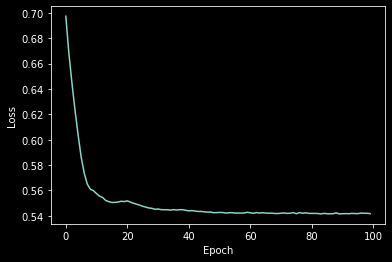

In [57]:
plt.plot(loss_val)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'F1 Micro')

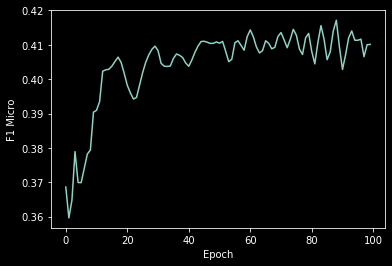

In [58]:
plt.plot(f1_val)
plt.xlabel('Epoch')
plt.ylabel('F1 Micro')